In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

from utils import *
import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from plottools import *
from scipy.integrate import quad

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


TODO:
Extend a Gaussian sampled at a large number of points and plot the contour map of the continuation
Implement Hardy basis optimization with a small number of H
Think about smearing in conjunction with this algorithm

In [2]:
# # Use a Gaussian spectral function centered at omega0 with width delOmega
# omega0 = 0.0
# delOmega = 1.0
# T = 64
# rho = lambda omega : 10 * np.exp(- (omega - omega0) ** 2 / (2 * (delOmega ** 2))) / (np.sqrt(2 * np.pi) * delOmega)
# omega_line = np.linspace(-5, 5, 1000)
# def signal(tau):
#     integrand = lambda omega : np.exp(-omega * tau) * rho(omega)
#     return quad(integrand, 0, np.inf)[0]
# rho_dat = np.array([rho(a) for a in omega_line])
# with sns.plotting_context('talk'):
#     fig, ax = plt.subplots(1, figsize = (10, 5))
#     plot_1d_function(ax, omega_line, rho_dat, colors = 'r', legend = False)

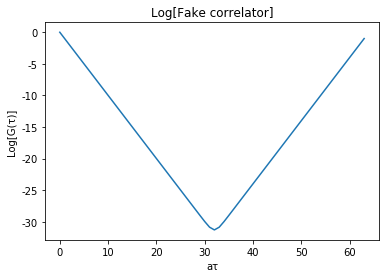

In [3]:
# Single delta spectral function
# m = 0.8
m = 1.
omega0 = m
T = 64
def signal(t):
    return np.exp(- m * t) + np.exp(- m * (T - t))
# x = np.linspace(0.1, T, 1000)
x = np.arange(T)
# x = np.arange(0, T, 1.)
plt.figure()
plt.plot(x, np.log(signal(x)))
plt.title('Log[Fake correlator]')
plt.ylabel('Log[G(τ)]')
plt.xlabel('aτ')
plt.show()

In [4]:
Nreal = 20000
omega_bounds = [-5, 5]
eta = 1e-2
np.random.seed(10)
# taus = np.arange(1, 25, 1.)
taus = np.arange(1, T - 1)
# taus = np.arange(T)
print('Evaluating Greens function at tau = it = ' + str(taus))

Evaluating Greens function at tau = it = [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62]


In [5]:
# change this up
theta_mp1 = lambda z : 0
# theta_mp1 = hardy(0)

In [6]:
Y = np.array([gmp.mpc(0, int(t)) for t in taus])
Cfloat = np.array([signal(t) for t in taus])
C = np.array([gmp.mpc(val) for val in Cfloat])
zmesh = np.linspace(omega_bounds[0], omega_bounds[1], num = Nreal)
zspace = np.array([gmp.mpc(z, eta) for z in zmesh])

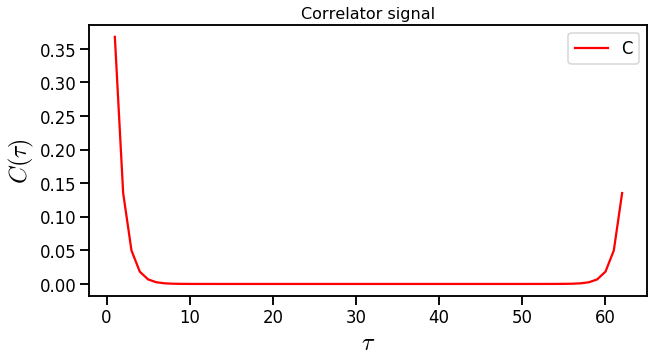

In [7]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, taus, Cfloat, fn_label = 'C', ax_label = ['$\\tau$', '$C(\\tau)$'], title = 'Correlator signal')

## FFT then continue

In [8]:
Ctilde_float = np.fft.fft(Cfloat)
Ctilde = np.array([gmp.mpc(z) for z in Ctilde_float])

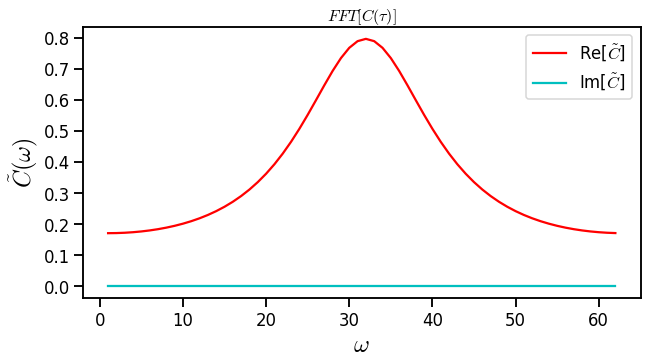

In [9]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, taus, np.fft.fftshift(Ctilde_float), fn_label = '$\\tilde{C}$', \
                        ax_label = ['$\\omega$', '$\\tilde{C}(\\omega)$'], title = '$FFT[C(\\tau)]$')

In [10]:
# Try continuing first
lambdas = np.array([h(z) for z in Ctilde])
Pick = construct_Pick(Y, lambdas)
print('Eigs are: ' + str(np.linalg.eigh(np.complex64(Pick))[0]))    # why are the eigenvalues always in \pm pairs?

Eigs are: [-1.5673499e+02 -6.1008372e+00 -3.7290584e-02 -5.6425938e-03
 -7.7918819e-05 -1.8769352e-06 -1.6229826e-06 -1.3129438e-06
 -1.1410693e-06 -9.8616727e-07 -8.7624755e-07 -7.2901173e-07
 -6.1250142e-07 -5.1465616e-07 -4.3380510e-07 -3.5241317e-07
 -3.3115577e-07 -3.0740213e-07 -2.7444301e-07 -2.5236650e-07
 -2.0910282e-07 -1.9643332e-07 -1.7702884e-07 -1.5342025e-07
 -1.1406698e-07 -1.0165312e-07 -8.0435214e-08 -7.5487748e-08
 -3.0773855e-08 -1.8866160e-08  8.7334771e-09  1.9370106e-08
  2.3904910e-08  3.5396422e-08  6.1657985e-08  7.0687371e-08
  9.5846858e-08  1.1103729e-07  1.2908566e-07  1.4590307e-07
  1.6900520e-07  2.0200443e-07  2.4749886e-07  2.5914312e-07
  2.9553664e-07  3.4084840e-07  4.1203700e-07  4.7366359e-07
  5.5752224e-07  6.2034155e-07  7.3972654e-07  8.4140072e-07
  9.0158903e-07  1.2219894e-06  1.3702756e-06  1.5410042e-06
  1.9008164e-06  7.7956742e-05  5.6425603e-03  3.7290592e-02
  6.1008372e+00  1.5673499e+02]


In [11]:
phis = construct_phis(Y, lambdas)
NGreal = analytic_continuation(Y, phis, zspace, theta_mp1)
NGreal_float = np.complex64(NGreal)

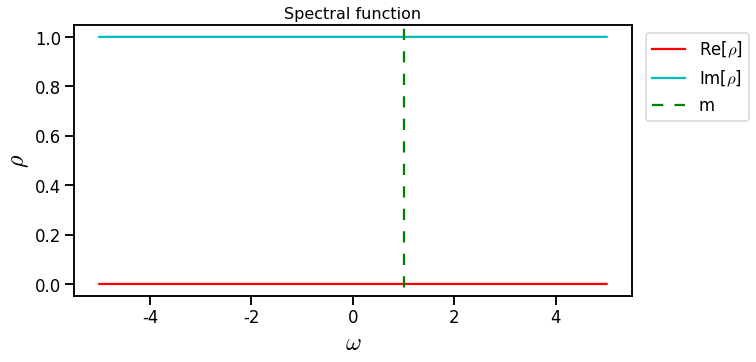

In [12]:
# other contexts: 'paper', 'poster', 'notebook'
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize=(10,5))
    plot_1d_function(ax, zmesh, NGreal_float, ax_label = ['$\\omega$', '$\\rho$'], title = 'Spectral function', \
                    fn_label = '$\\rho$', legend = False)
    add_line(ax, omega0, color = 'g', dashes = (5, 5), label = 'm')
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')